In this notebook, we are going to create a Pascal VOC (kinda) version of Calcium OCT (from Sohee's)

The goal is for MMSeg to be able to read and use. Subsequently, RADIO and DINOv2 can use it for their linear probing semantic segmentaion of their feature map.

In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import cv2
from PIL import Image
import json

In [ ]:
def get_color_map():
    rbg_map = np.array([
        [0, 0, 0], # background
        [128, 0, 0], # calcium
    ])
    label_map = [
        'background',
        'calcium'
    ]

    with open(output_root_dir / 'colors.txt', 'w') as f:
        for i in range(rbg_map.shape[0]):
            f.write(f"{label_map[i]} {rbg_map[i][0]} {rbg_map[i][1]} {rbg_map[i][2]}\n")
    return rbg_map

def save_image(image, path):
    cv2.imwrite(str(path), image)

def load_nii(path):
    return nib.load(path).get_fdata()

def prepare_folder_structure(output_root_dir):
    output_root_dir = Path(output_root_dir)
    output_root_dir.mkdir(parents=True, exist_ok=True)

    image_dir = output_root_dir / "JPEGImages"
    segmentation_dir = output_root_dir / "SegmentationClass"
    imagesets_dir = output_root_dir / "ImageSets"

    image_dir.mkdir(exist_ok=False)
    
    segmentation_dir.mkdir(exist_ok=True)
    imagesets_dir.mkdir(exist_ok=True)

    return output_root_dir, image_dir, segmentation_dir, imagesets_dir

output_root_dir, image_dir, segmentation_dir, imagesets_dir = prepare_folder_structure(output_root_dir = "/storage_bizon/naravich/datasets/CalciumOCT_VOC")

nii_data_root = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_raw/Dataset302_Calcium_OCTv2/')
split_path = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_preprocessed/Dataset302_Calcium_OCTv2/splits_final.json')

rbg_map = get_color_map()
for TrOrTs in ['Tr', 'Ts']:
    nii_image_dir = nii_data_root / f"images{TrOrTs}"
    nii_segmentation_dir = nii_data_root / f"labels{TrOrTs}"
    for nii_image_path in nii_image_dir.glob("*.nii.gz"):
        imag_name = nii_image_path.name[:-len('_0000.nii.gz')]
        label_name = imag_name + ".nii.gz"
        nii_segmentation_path = nii_segmentation_dir / label_name

        image = load_nii(nii_image_path)
        image = image.astype(np.float32) * 255
        image = 2 * image
        assert image.max() <= 255
        segmentation = load_nii(nii_segmentation_path)

        num_images = image.shape[2] # slice in z-axis
        for i in range(num_images):
            image_slice = image[:, :, i]
            segmentation_slice = segmentation[:, :, i]
            
            rgb_image = cv2.cvtColor(image_slice, cv2.COLOR_GRAY2RGB)
            gray_segmentation = Image.fromarray(segmentation_slice.astype(np.uint8), mode='L')

            image_name_index = f"{imag_name}_{i:03d}"
            save_image(rgb_image, image_dir / f"{image_name_index}.jpg")
            gray_segmentation.save(segmentation_dir / f"{image_name_index}.png")
            if TrOrTs == 'Tr':
                with open(imagesets_dir / "train_all.txt", "a") as f:
                    f.write(f"{image_name_index}\n")
            else:
                with open(imagesets_dir / "test.txt", "a") as f:
                    f.write(f"{image_name_index}\n")


with open(imagesets_dir / "train_all.txt", "r") as f:
    all_images = f.readlines()
    all_images = [x.strip() for x in all_images]

with open(split_path, "r") as f:
    split = json.load(f)

for fold, split_train_val in enumerate(split):
    train = split_train_val['train']
    train = set(train)
    val = split_train_val['val']
    val = set(val)

    train_images = [x for x in all_images if x.split('_')[0] in train]
    val_images = [x for x in all_images if x.split('_')[0] in val]
    
    
    with open(imagesets_dir / f"train_{fold}.txt", "w") as f:
        for image in train_images:
            f.write(f"{image}\n")
    with open(imagesets_dir / f"val_{fold}.txt", "w") as f:
        for image in val_images:
            f.write(f"{image}\n")
            

In [ ]:
'101-044_204'

In [2]:
root_dir = Path("/storage_bizon/naravich/datasets/CalciumOCT_VOC")
segmentation_dir = root_dir / "SegmentationClass"
for segmentation_path in segmentation_dir.glob("*.png"):
    if '101-044_204' not in segmentation_path.name:
        continue
    segmentation = Image.open(segmentation_path, mode='r')
    segmentation = np.array(segmentation)
    if not np.all(segmentation == 0):
        print(segmentation_path.name)
        break

101-044_204.png


In [3]:
segmentation_path

PosixPath('/storage_bizon/naravich/datasets/CalciumOCT_VOC/SegmentationClass/101-044_204.png')

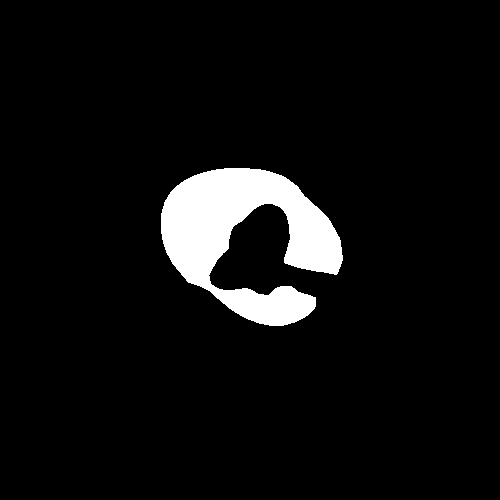

In [4]:
segmentation = Image.open(segmentation_path, mode='r')
segmentation = np.array(segmentation) * 255
Image.fromarray(segmentation.astype(np.uint8), mode='L')

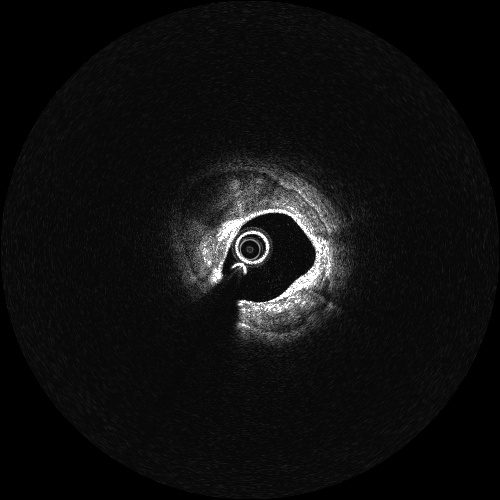

In [5]:
img_path = (root_dir / "JPEGImages" / "101-044_204.jpg")
img = Image.open(img_path)
img

In [6]:
def load_nii(path):
    return nib.load(path).get_fdata()

In [7]:
nii_data_root = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_raw/Dataset302_Calcium_OCTv2/')
nii_path = nii_data_root / "imagesTr" / "101-044_0000.nii.gz"
label_nii_path = nii_data_root / "labelsTr" / "101-044.nii.gz"
image = load_nii(nii_path)
image = image.astype(np.float32) * 255
image = 2 * image
assert image.max() <= 255
label_nii = load_nii(label_nii_path)


In [8]:
image[:, :, 204].shape

(500, 500)

In [9]:
image[:, :, 204].max()

253.8768

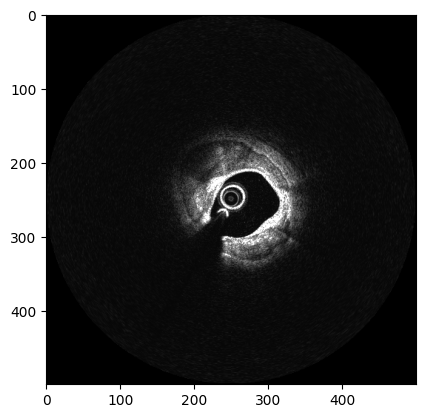

In [10]:
import matplotlib.pyplot as plt
plt.imshow(image[:, :, 204], cmap='gray')

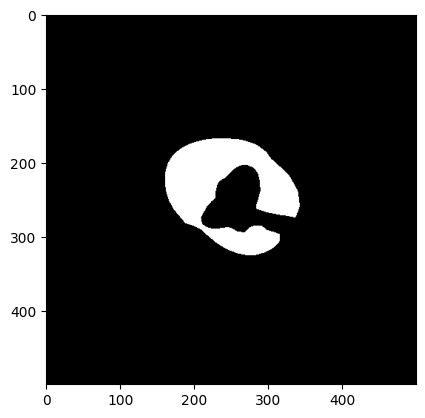

In [11]:
plt.imshow(label_nii[:, :, 204], cmap='gray')

In [18]:
(label_nii == i).shape

(500, 500, 404)

In [20]:
label_nii_rgb = np.zeros((label_nii.shape[0], label_nii.shape[1], 3), dtype=np.uint8)
rbg_map = np.array([
    [0, 0, 0], # background
    [128, 0, 0], # calcium
])
for i, color in enumerate(rbg_map):
    label_nii_rgb[(label_nii[:, :, 204] == i)] = color


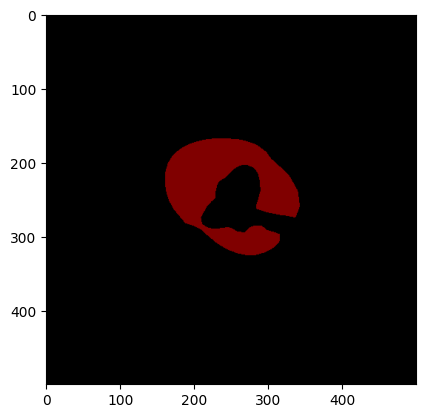

In [21]:
plt.imshow(label_nii_rgb)

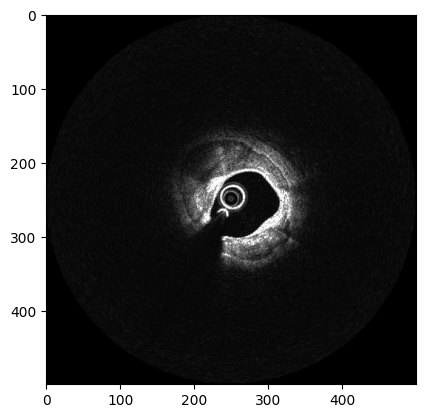

In [28]:
image_rbg = cv2.cvtColor(image[:, :, 204], cv2.COLOR_GRAY2RGB).astype(np.uint8)
plt.imshow(image_rbg)

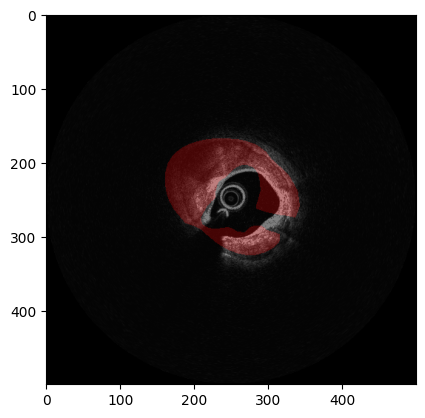

In [30]:
overlay = cv2.addWeighted(image_rbg, 0.5, label_nii_rgb, 0.5, 0)
plt.imshow(overlay)

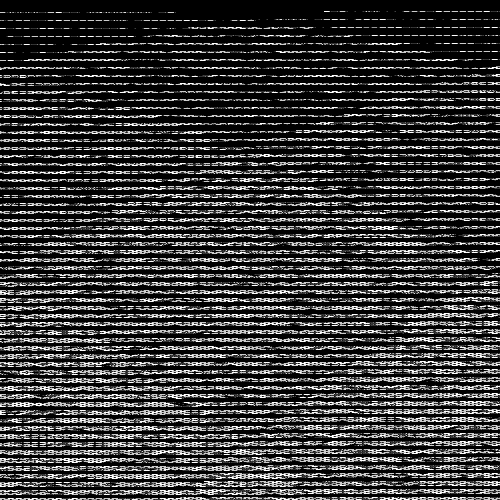

In [40]:
image_nii = Image.fromarray(image[:, :, 204] * 255, mode='L')
image_nii